# Algorithmic Differentiation Example

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader

# from torchvision import datasets
# from torchvision.transforms import ToTensor

from torch.utils.data import Dataset
from torch.utils.data import random_split
from torch.utils.tensorboard import SummaryWriter

In [3]:
import sys

sys.path.append("../../CODE/TorchLearning")

import charts
import diffdeeplearnmodels as diff



## Test diff model sensitivities

tensor([[ 0.0246, -0.0067, -0.0036,  0.0077,  0.0116, -0.0055],
        [ 0.0337, -0.0076, -0.0032,  0.0079,  0.0114, -0.0041],
        [ 0.0238, -0.0058, -0.0042,  0.0073,  0.0117, -0.0064],
        [ 0.0217, -0.0075, -0.0036,  0.0087,  0.0111, -0.0062],
        [ 0.0249, -0.0076, -0.0034,  0.0088,  0.0113, -0.0057],
        [ 0.0264, -0.0069, -0.0036,  0.0073,  0.0114, -0.0049],
        [ 0.0332, -0.0072, -0.0035,  0.0072,  0.0111, -0.0050],
        [ 0.0202, -0.0079, -0.0033,  0.0089,  0.0115, -0.0050],
        [ 0.0211, -0.0062, -0.0044,  0.0070,  0.0114, -0.0059],
        [ 0.0238, -0.0073, -0.0034,  0.0082,  0.0114, -0.0053]],
       dtype=torch.float64, grad_fn=<CatBackward0>)
tensor([-0.0055, -0.0041, -0.0064, -0.0062, -0.0057, -0.0049, -0.0050, -0.0050,
        -0.0059, -0.0053], dtype=torch.float64, grad_fn=<DivBackward0>)


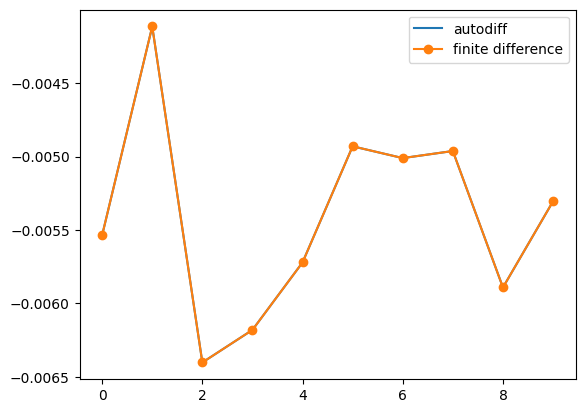

In [16]:
model =  diff.DenseModel(num_inputs=5, num_hidden_layers=3, num_neurons_per_hidden_layer=64)

algdiffmodel = diff.DiffDeepLearning(model)


x = torch.rand(10, 5, dtype=torch.float64, requires_grad=True)

y = algdiffmodel(x)

print(y)

col = 4
ep = 1e-6

x__ = x.clone()

x__[:, col] += torch.tensor(ep)

y2 = algdiffmodel(x__)

test = (y2[:, 0] - y[:, 0]) / ep

print(test)

plt.plot(y[:,col+1].detach().numpy(), label='autodiff')

plt.plot(test.detach().numpy(), label='finite difference', marker='o')

plt.legend()

torch.save(algdiffmodel, "../../TEST_MODELS/algdiffmodel.pth")

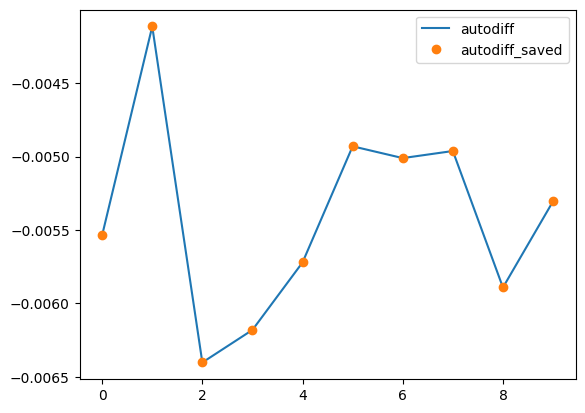

In [17]:
saved_dense = torch.load("../../TEST_MODELS/algdiffmodel.pth", weights_only=False)

y_saved = saved_dense(x) 

plt.plot(y[:,col+1].detach().numpy(), label='autodiff')
plt.plot(y_saved[:,col+1].detach().numpy(), 'o',label='autodiff_saved')
plt.legend()




## Train model


### Sample data

In [7]:
ep = 0.3 # error term
num = 20000 #num poins

X = np.random.uniform(-4*np.pi,4*np.pi, (num,1))
Y = np.random.uniform(-4*np.pi,4*np.pi, (num,1))

XXX = np.hstack((X,Y))




X_torch = torch.tensor(X, dtype= torch.float64, requires_grad=True)
Y_torch = torch.tensor(Y, dtype= torch.float64, requires_grad=True)


Z = torch.sin(torch.sqrt(X_torch**2+Y_torch**2))+ ep*torch.randn((num,1))

print(Z)

Z.sum().backward()

print(X_torch.grad)

Z= Z.detach().numpy()

Z = np.concatenate((Z, X_torch.grad.numpy(), Y_torch.grad.numpy())      , axis=1) 

np.save('../../DATA/x2d_train.npy', XXX[0:18000,:])
np.save('../../DATA/y2d_train.npy', Z[0:18000,:])
np.save('../../DATA/x2d_test.npy', XXX[18000:,:])
np.save('../../DATA/y2d_test.npy', Z[18000:,:])

df = pd.DataFrame({
    "x": XXX[:,0],
    "y": XXX[:,1],
    "z": Z[:,0],
    "dz_dx": Z[:,1], "dz_dy": Z[:,2]
})

df[['x','y', 'z']]





tensor([[-0.4488],
        [ 0.0669],
        [ 0.8550],
        ...,
        [ 0.7344],
        [-0.5639],
        [-0.0718]], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([[ 0.1820],
        [ 0.8859],
        [-0.1847],
        ...,
        [-0.2654],
        [-0.3350],
        [-0.0927]], dtype=torch.float64)


x          y         z
0       2.770917  11.565017 -0.448814
1      -9.902200  -0.288359  0.066933
2       6.996326  -4.019188  0.854976
3       5.644011 -11.902299  0.607746
4      12.410550   8.961331  0.438507
...          ...        ...       ...
19995   7.963129   6.883284 -0.807416
19996  -6.639726   2.768807  0.970992
19997   7.374374  -3.474066  0.734432
19998   5.731260  -8.613723 -0.563896
19999  -1.191179  12.206824 -0.071834

[20000 rows x 3 columns]

In [8]:
f = charts.plot_3d_scatter(df, 'x', 'y', 'dz_dx')

charts.plot_3d_scatter(df, 'x', 'y', 'dz_dy', f, color = 'red')

charts.plot_3d_scatter(df, 'x', 'y', 'z', f, color = 'green')

f.show()


### Data set

In [9]:
train_dataset = diff.DiffDeepLearningDataset('../../DATA/x2d_train.npy', '../../DATA/y2d_train.npy')
test_dataset = diff.DiffDeepLearningDataset('../../DATA/x2d_test.npy', '../../DATA/y2d_test.npy')  


In [13]:
model = diff.DiffLearningFullModel(num_inputs=2, num_hidden_layers=3, num_neurons_per_hidden_layer=64, alpha=1.0, 
                            train_dataloader=DataLoader(train_dataset, batch_size=64, shuffle=True), 
                            val_dataloader=DataLoader(test_dataset, batch_size=test_dataset.__len__()))


model.train(epochs=20)

Epoch 1, Train Loss: 2.0204, Val Loss: 2.0102
Epoch 2, Train Loss: 2.0005, Val Loss: 2.0092
Epoch 3, Train Loss: 2.0011, Val Loss: 2.0101
Epoch 4, Train Loss: 1.9997, Val Loss: 2.0102
Epoch 5, Train Loss: 2.0012, Val Loss: 2.0108
Epoch 6, Train Loss: 2.0003, Val Loss: 2.0091
Epoch 7, Train Loss: 2.0000, Val Loss: 2.0050
Epoch 8, Train Loss: 1.9961, Val Loss: 1.9999
Epoch 9, Train Loss: 1.9933, Val Loss: 2.0034
Epoch 10, Train Loss: 1.9925, Val Loss: 1.9804
Epoch 11, Train Loss: 1.6958, Val Loss: 1.4339
Epoch 12, Train Loss: 1.0485, Val Loss: 0.6115
Epoch 13, Train Loss: 0.4828, Val Loss: 0.5299
Epoch 14, Train Loss: 0.4634, Val Loss: 0.5572
Epoch 15, Train Loss: 0.4603, Val Loss: 0.4991
Epoch 16, Train Loss: 0.4567, Val Loss: 0.5269
Epoch 17, Train Loss: 0.4531, Val Loss: 0.5142
Epoch 18, Train Loss: 0.4554, Val Loss: 0.5011
Epoch 19, Train Loss: 0.4527, Val Loss: 0.5042
Epoch 20, Train Loss: 0.4518, Val Loss: 0.5353


In [14]:
def f(x, y):
    return np.sin(np.sqrt(x**2 + y**2))

fig = charts.plot_3d_scatter(df, 'x', 'y', 'z', color = 'green')



charts.plot_surface_with_contours(f, x_min=-4*np.pi, x_max=4*np.pi, y_min=-4*np.pi, y_max=4*np.pi, n_points=150, color="black", fig=fig)
fig.show()

In [15]:
ff = lambda x, y: model.forward(torch.tensor(np.hstack((x.reshape(-1,1), y.reshape(-1,1))), dtype=torch.float64))['y']



fig = charts.plot_surface_with_contours(ff, x_min=-4*np.pi, x_max=4*np.pi, y_min=-4*np.pi, y_max=4*np.pi, n_points=150, color="orange", fig=fig)

fig.show()

### Test model sens in training for single layer